sbatch SpikeCounter/cluster/run_array_autosegmentation.sh /n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/analysis/experiment_data.csv /n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected 1 0 5 3 375 0.01 0.52 0.8 0.15 2.5

In [1]:
import sys
sys.path.append("../SpikeCounter")
from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize
from statannotations.Annotator import Annotator

In [11]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from datetime import datetime
import scipy.signal as signal
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.optimize as optimize
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.lines as mlines
import matplotlib.colors as colors
import seaborn as sns
import os
from scipy.io import savemat, loadmat
from skimage import transform, measure
import skimage.io as skio
import importlib
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")

In [3]:
importlib.reload(visualize)
importlib.reload(images)
importlib.reload(traces)

<module 'spikecounter.analysis.traces' from '/n/holyscratch01/cohen_lab/bjia/notebooks/../SpikeCounter/spikecounter/analysis/traces.py'>

In [4]:
rootdir = "/n/cohen_lab/Lab/Labmembers/Bill Jia/Data/Firefly/"
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures"

In [5]:
folders = ["20210420_gcamp_widefield", "20210716_gcamp_widefield", "20210724_gcamp_widefield"]

In [6]:
peaks_data = pd.read_csv(os.path.join(rootdir, folders[0], "analysis/peaks_data.csv")).set_index("roi")
dFF = loadmat(os.path.join(rootdir, folders[0], "analysis/dFFs.mat"))['dFF']

In [23]:
fluctuation_data = []
total_embryo_offset = 0
isi_threshold = 120
for f in folders:
    peaks_data = pd.read_csv(os.path.join(rootdir, f, "analysis/peaks_data.csv")).set_index("roi")
    dFF = loadmat(os.path.join(rootdir, f, "analysis/dFFs.mat"))['dFF']
    for roi in peaks_data.index.unique():
        isi = peaks_data.loc[roi, "isi"].to_numpy()
        first_pk_idx = np.argwhere((isi< isi_threshold) & (np.roll(isi,-1) < isi_threshold)).ravel()[0]
        first_pk_idx = peaks_data.loc[roi,"peak_idx"].iloc[first_pk_idx]
        peak_height = dFF[roi, first_pk_idx] - np.nanmean(dFF[roi, max(first_pk_idx-1200,0):first_pk_idx])
        pre_std = np.nanstd(dFF[roi, max(first_pk_idx-1200,0):first_pk_idx-10])
        pre_max_fluct = np.nanmax(np.abs(dFF[roi, max(first_pk_idx-1200,0):first_pk_idx-10]-\
                                  np.nanmean(dFF[roi, max(first_pk_idx-1200,0):first_pk_idx])))
        pre_max_fluct_idx = np.nanargmax(np.abs(dFF[roi, max(first_pk_idx-1200,0):first_pk_idx-10]-\
                                  np.nanmean(dFF[roi, max(first_pk_idx-1200,0):first_pk_idx]))) + max(first_pk_idx-1200,0)
        fluctuation_data.append((total_embryo_offset, first_pk_idx, peak_height, pre_std,\
                                 pre_max_fluct_idx, pre_max_fluct,f,roi))
        total_embryo_offset +=1

In [24]:
df = pd.DataFrame(fluctuation_data, columns=["embryo", "first_pk_idx", "first_pk_height", "pre_peak_std",\
                            "pre_peak_max_idx", "pre_peak_max", "folder", "folder_embryo"])

In [25]:
df["peak_std_ratio"] = df["first_pk_height"]/df["pre_peak_std"]
df["peak_pre_max_ratio"] = df["first_pk_height"]/df["pre_peak_max"]

In [15]:
df.to_csv(os.path.join(figdir, "Data", "first_peak_noise_comparison.csv"), index=False)

In [7]:
df = pd.read_csv(os.path.join(figdir, "Data", "first_peak_noise_comparison.csv"))

In [8]:
f = 0
peaks_data = pd.read_csv(os.path.join(rootdir, folders[f], "analysis/peaks_data.csv")).set_index("roi")
dFF = loadmat(os.path.join(rootdir, folders[f], "analysis/dFFs.mat"))['dFF']

In [40]:
peaks_data.loc[9]

,peak_idx,prominence,fwhm,isi,t,hpf
roi,,,,,,
9,37520,0.010673,1.969547,103.627451,4038.431373,20.121786
9,38577,0.009242,1.873393,60.392157,4142.058824,20.150572
9,39193,0.010451,1.725103,35.490196,4202.450980,20.167347
9,39555,0.009144,1.139493,75.784314,4237.941176,20.177206
9,40328,0.008519,2.173325,34.607843,4313.725490,20.198257
...,...,...,...,...,...,...
9,187987,0.008566,0.630798,92.745098,18790.098039,24.219472
9,188933,0.008989,1.514009,92.156863,18882.843137,24.245234
9,189873,0.009108,0.613702,9.901961,18975.000000,24.270833


In [41]:
df

,embryo,first_pk_idx,first_pk_height,pre_peak_std,pre_peak_max_idx,pre_peak_max,folder,folder_embryo,peak_std_ratio,peak_pre_max_ratio
0,0,75118,0.018591,0.001444,74331,0.003917,20210420_gcamp_widefield,0,12.875862,4.746389
1,1,67068,0.050125,0.002834,66807,0.008274,20210420_gcamp_widefield,1,17.684013,6.058396
2,2,98933,0.036044,0.001844,98092,0.003826,20210420_gcamp_widefield,2,19.547671,9.421379
3,3,33469,0.021826,0.001674,33113,0.005347,20210420_gcamp_widefield,3,13.039743,4.082235
4,4,52081,0.043111,0.002116,52032,0.006050,20210420_gcamp_widefield,4,20.374776,7.126045
5,5,51818,0.062341,0.002095,51148,0.004816,20210420_gcamp_widefield,5,29.750634,12.943422
6,6,48157,0.016280,0.004482,47214,0.009652,20210420_gcamp_widefield,6,3.632068,1.686717
7,7,62473,0.019100,0.001708,61349,0.006295,20210420_gcamp_widefield,7,11.181786,3.034142
8,8,60048,0.020652,0.001243,59403,0.003771,20210420_gcamp_widefield,8,16.621454,5.476614
9,9,37520,0.013055,0.002456,36792,0.010131,20210420_gcamp_widefield,9,5.315441,1.288618


38577
37520


(37377.0, 38677.0)

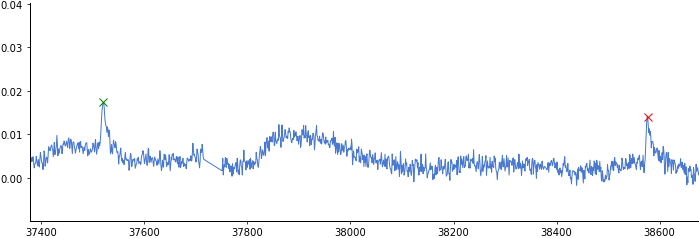

In [20]:
roi = 9
first_pk_idx = df.iloc[roi]["first_pk_idx"]
pre_peak_max_idx = df.iloc[roi]["pre_peak_max_idx"]
print(first_pk_idx)
print(pre_peak_max_idx)

xmax = first_pk_idx+100
xmin = first_pk_idx-1200

fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(dFF[roi])
ax1.plot(first_pk_idx, dFF[roi, first_pk_idx], "rx")
ax1.plot(pre_peak_max_idx, dFF[roi, pre_peak_max_idx], "gx")

ax1.set_xlim(xmin, xmax)

In [94]:
peaks_data.loc[roi]

,peak_idx,prominence,fwhm,isi,t,hpf
roi,,,,,,
9,39556,0.009916,1.089789,25.784314,4238.039216,20.177233
9,39819,0.009812,9.274984,43.627451,4263.823529,20.184395
9,40264,0.009824,0.977591,132.941176,4307.450980,20.196514
9,41620,0.008901,1.248397,10.784314,4440.392157,20.233442
9,41730,0.009942,1.296755,35.392157,4451.176471,20.236438
...,...,...,...,...,...,...
9,191008,0.008349,0.470067,2.058824,19086.274510,24.301743
9,191029,0.011658,0.490940,0.980392,19088.333333,24.302315
9,191039,0.008507,0.567841,3.137255,19089.313725,24.302587


(array([4., 2., 5., 5., 2., 6., 6., 4., 3., 2.]),
 array([-0.33952135,  0.08396745,  0.50745625,  0.93094506,  1.35443386,
         1.77792267,  2.20141147,  2.62490028,  3.04838908,  3.47187788,
         3.89536669]),
 <BarContainer object of 10 artists>)

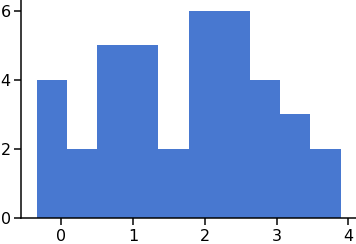

In [7]:
fig1, ax1 = plt.subplots(figsize=(6,4))
# ax1.hist(np.exp(np.log(df["peak_pre_max_ratio"])/np.log(10)), log=True)
ax1.hist(np.log2(df["peak_pre_max_ratio"]))

# ax1.set_xticks([0,1,2,3,4,5, 10, 15])

In [9]:
df_first_pk = pd.DataFrame(df["first_pk_height"].values, columns=["amplitude"])
df_first_pk["group"] = "First peak"
df_fluct = pd.DataFrame(df["pre_peak_max"].values, columns=["amplitude"])
df_fluct["group"] = "Pre-peak"
df_peaks_combined = pd.concat([df_first_pk, df_fluct], axis=0)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pre-peak vs. First peak: t-test paired samples, P_val:8.620e-09 t=-7.338e+00


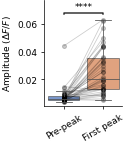

In [12]:
x="group"
y="amplitude"

fig1, ax1 = plt.subplots(figsize=(2*0.7,3*0.65))
order  = ["Pre-peak", "First peak"]

for idx in df_first_pk.index.unique():
    offset = 0.5
    x1 = 0.5-offset
    x2 = 0.5+offset
    ax1.plot([x1, x2], [df_fluct.loc[idx,y], df_first_pk.loc[idx,y]], ".-", color="k", alpha=0.2)
#     sns.swarmplot(data=freq_compare, x=x, y=y,ax=ax1, order=order, palette=["k"], size=3, hue=hue_title, dodge=True)
#     sns.barplot(data=freq_compare, x=x, y=y,ax=ax1, order=order, palette=cs, hue=hue_title,\
#                hue_order=hue_order)
sns.boxplot(data=df_peaks_combined, x=x, y=y,ax=ax1, order=order, boxprops={"alpha": 0.8}, fliersize=0)
#     print(ax1.get_xticks())
#     sns.barplot(x=x, y=y, hue=hue_title,\
#                 data = freq_compare, ax=ax1, ci="sd", order=order,\
#                hue_order=hue_order, capsize=0.05)

# ax1.set_ylim(-0.05, 1.5)
# ax1.set_xtick_labels()
ax1.set_xlabel("")
ax1.set_ylabel(r"Amplitude ($\Delta F / F$)")
pairs = [("Pre-peak", "First peak")]
# for patch, color in zip(bplot['boxes'], cs):
#     patch.set_facecolor(color)
#     ax1.set_yticks([0,0.5,1,1.5,2])
annot = Annotator(ax1, pairs, data=df_peaks_combined, x=x,y=y, order=order)
annot.configure(test="t-test_paired", verbose=2)
annot.apply_and_annotate()
plt.xticks(rotation=30)
plt.savefig(os.path.join(figdir, "Supplementary Figures/spike_waveforms/first_vs_noise.svg"))

In [58]:
np.std(df["peak_pre_max_ratio"])

2.771598085165484

In [49]:
np.log10(np.e)

0.4342944819032518